# Práticas com Machine Learning

O dataset utilizado para a prática deste script é um conjunto de dados referente a alguns indicadores de cidades, conforme abaixo:

- ind_pop_cid = índice entre 1 e 5, indicando o tamanho da população de uma cidade; quanto maior o índice, maior a cidadel;
- perc_pol = percentual de policiais ativos na cidade;
- taxa_crim = taxa de criminalidade histórica da cidade;
- nivel_ed = nível educacional médio da cidade;
- crimes = quantidade de crimes registrados no mês vigente;

O objetivo neste script visou aplicar algumas técnicas para preparação do dataframe para validar a generalização do melhor modelo de predição para prever a variável crimes. Para também facilitar a visualização do overfitting e underfitting, foram realizadas algumas plotagens do comportamento dos modelos em dataframes de treino e teste, com a mensuração do RMSE para validar o desempenho deste em cada caso.

Importação das bibliotecas e a criação do dataframe:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import requests

import pandas_profiling
from pandas_profiling.utils.cache import cache_file

df = pd.read_csv("dataframe_exercicio_modulo_8.csv")
print(df.shape)
df.head()

(2460, 5)


,ind_pop_cid,perc_pol,taxa_crim,nivel_ed,crimes
0,1.0,7.185471,62.082693,10.0,77
1,1.0,24.456750,88.244380,6.0,202
2,1.0,19.791772,94.930257,1.0,348
3,4.0,10.089496,41.791507,6.0,114
4,3.0,34.697495,67.615795,1.0,47


# Avaliação sobre Pandas Profiling

Aplicação do Pandas Profiling para analisar o dataframe estatisticamente:

In [3]:
report = df.profile_report(
    sort=None, html={"style": {"full_width": True}}, progress_bar=False
)
report

Ainda sobre a tabela, podemos verificar algumas informações importantes:

- As variáveis perc_pol, taxa_crim, nivel_ed e crimes são numéricas/float e a variável ind_pop_cid também é numérica/int;
- Todas as variáveis numéricas possuem um desvio padrão alto em relação a média, mostrando a heterogeneidade das variáveis do dataframe;
- A variável crimes possui uma grande amplitude, visto que a diferença entre o maior e o menor valor de 529000;
- A variável perc_pol tem correlação negativa em relação aos crimes, ou seja, quanto maior é o percentual de policiais na cidade, menor é a taxa de crimes;
- A variável taxa_crim tem correlação positiva em relação aos crimes, ou seja, quanto maior é a taxa histórica de crimes na cidade, maior é a taxa de crimes;

# Divisão do modelo entre treino e teste

Criação de função para divisão de dataframe entre treino e teste:

In [4]:
def train_test_split (df, percentual_teste):
    num_linhas_teste = df.shape[0]*percentual_teste
    df_teste = df.loc[:num_linhas_teste-1]
    df_treino_temp = df.loc[num_linhas_teste:]
    df_treino = df_treino_temp.loc[num_linhas_teste-1:]
    return df_treino, df_teste

Aplicação de função train/test split:

In [5]:
df_treino, df_teste = train_test_split(df, 0.25)

Validação da porcentagem do dataframe de treino:

In [6]:
len(df_treino)/len(df)

0.75

Validação da porcentagem do dataframe de teste:

In [7]:
len(df_teste)/len(df)

0.25

# Treinamento dos modelos com uma variável preditora

Para avaliação do desempenho dos modelos de Machine Learning, uma das técnicas que podem ser utilizadas é o MSE (Mean Square Error), que é representado pela fórmula:
    
###  $1/{N} \cdot \sum_i{(y_i - y_{pred_i})^{2}}$,

onde a soma é feita em todas as linhas do dataset e N é a quantidade de linhas deste.

__Uma variação desta métrica que também tem utilização na área de ML é a raíz quadrada do erro médio quadrático, representada por RMSE, calculada por meio da raiz quadrada do MSE.__

Criação das funções MSE e RMSE:

In [8]:
def MSE(y, y_pred):
    return np.mean((y - y_pred)**2)

def RMSE(y, y_pred):
    return np.sqrt(np.mean((y - y_pred)**2))

Importação das bibliotecas de Regressão Linear e KNeighbors Regressor;

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

Para o treinamento dos modelos, foi escolhida a variável taxa_crim para predizer a variável crimes, dado que esta possui maior correlação de Pearson (0.578659). Abaixo, foram criados os dataframes de treino e teste das variáveis preditora (x) e alvo (y):

In [10]:
X = df_treino['taxa_crim'].values.reshape(-1,1)
y = df_treino['crimes'].values
Xi = df_teste['taxa_crim'].values.reshape(-1,1)
yi = df_teste['crimes'].values

Criação de função para plotagem dos gráficos de aderência dos modelos ao dataframe:

In [11]:
def plota_curva_regressao(X, y, Xi, yi, modelo, nome_modelo):
    
    modelo.fit(X, y)
    
    predicao_dataset_treino = modelo.predict(X)
    predicao_dataset_teste = modelo.predict(Xi)
    
    rmse_dataset_treino = np.round(RMSE(y = y, y_pred = predicao_dataset_treino), 2)
    rmse_dataset_teste = np.round(RMSE(y = yi, y_pred = predicao_dataset_teste), 2)
    
    plt.figure(figsize = [20,6])
    plt.subplot(1,2,1)
    plt.title("Modelo: " + nome_modelo + " ~ RMSE DATASET TREINO: " + str(rmse_dataset_treino),
              fontsize = 14, fontweight = 'bold')
    plt.scatter(X, y, c = 'gray', s = 25)
    plt.plot(X, predicao_dataset_treino, c = 'blue', lw = 2, label = 'predição ')
    plt.legend(fontsize = 14)
    plt.grid()
    plt.subplot(1,2,2)
    plt.title("Modelo: " + nome_modelo + " ~ RMSE DATASET TESTE: " + str(rmse_dataset_teste),
              fontsize = 14, fontweight = 'bold')
    plt.scatter(Xi, yi, c = 'gray', s = 25)
    plt.plot(Xi, predicao_dataset_teste, c = 'blue', lw = 2, label = 'predição ')
    plt.legend(fontsize = 14)
    plt.grid()
    plt.show()

Aplicação da função de plotagem para análise do comportamento dos modelos entre treino e teste:

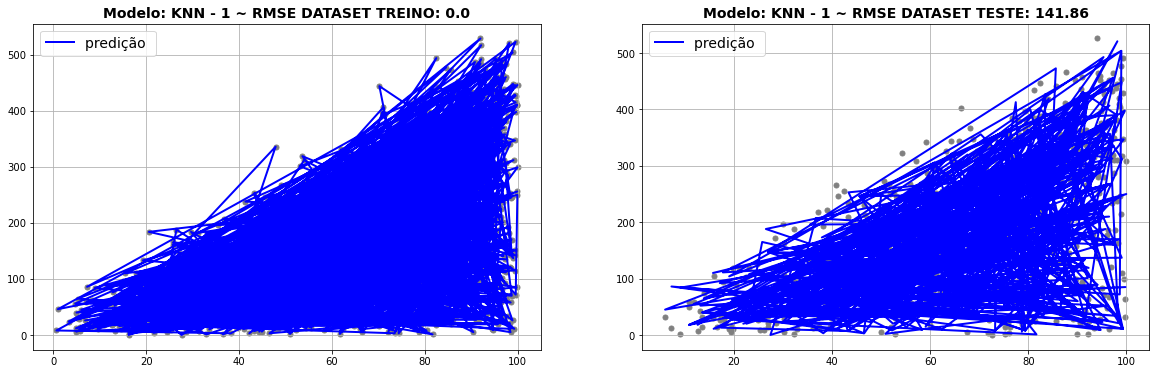

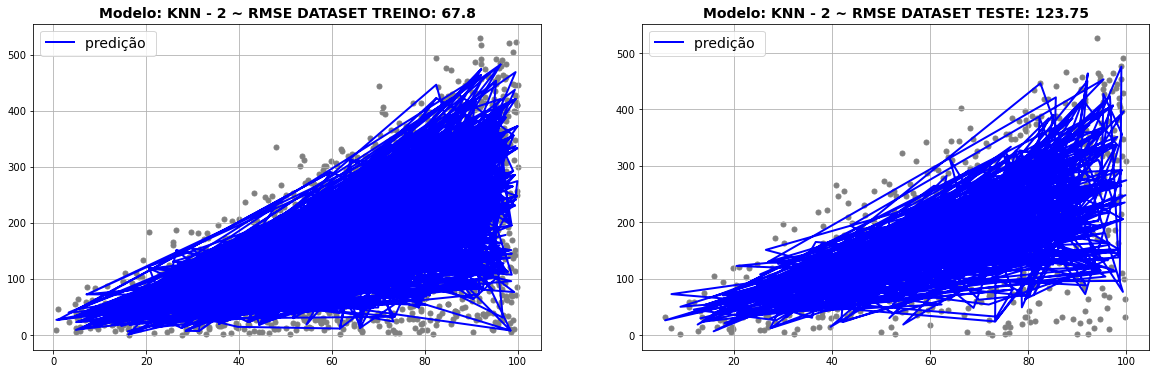

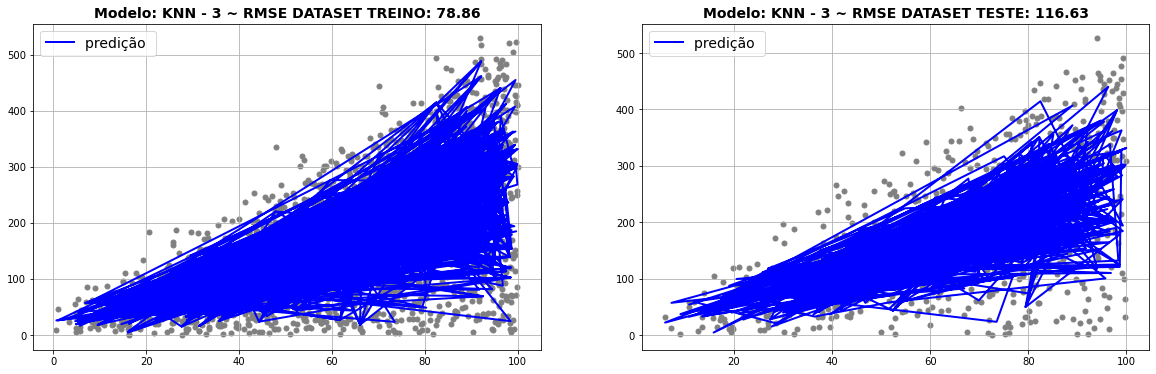

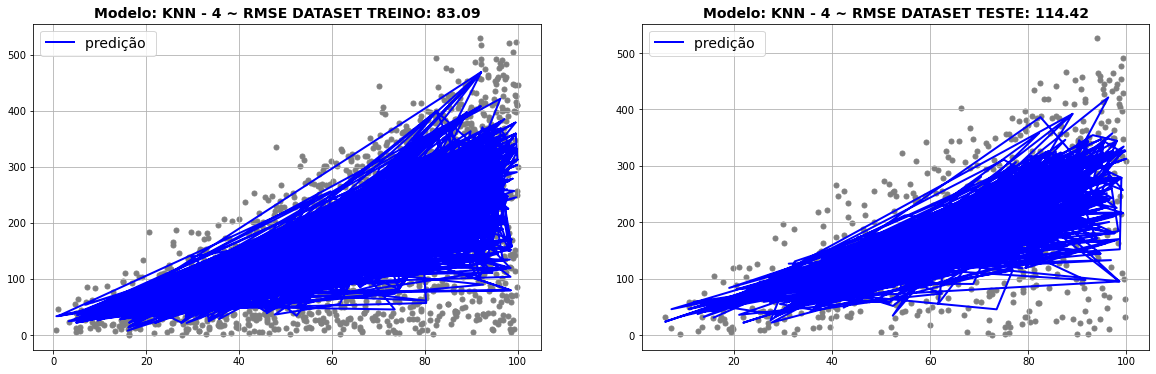

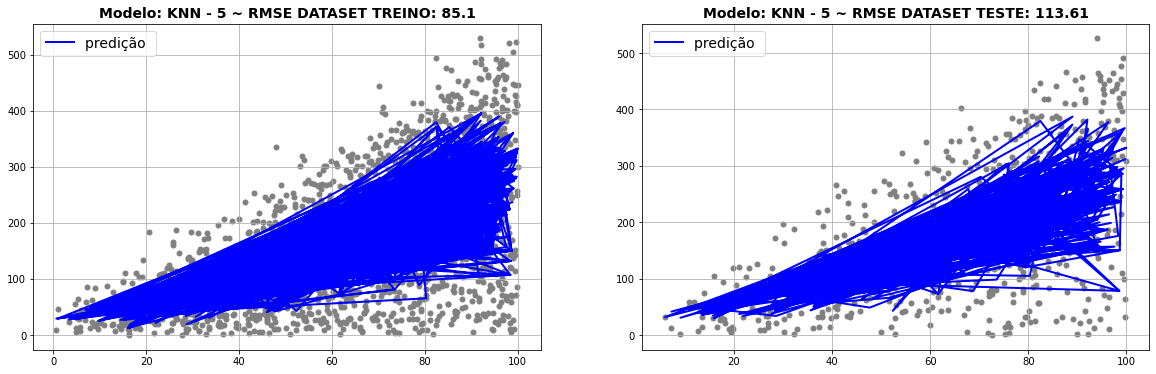

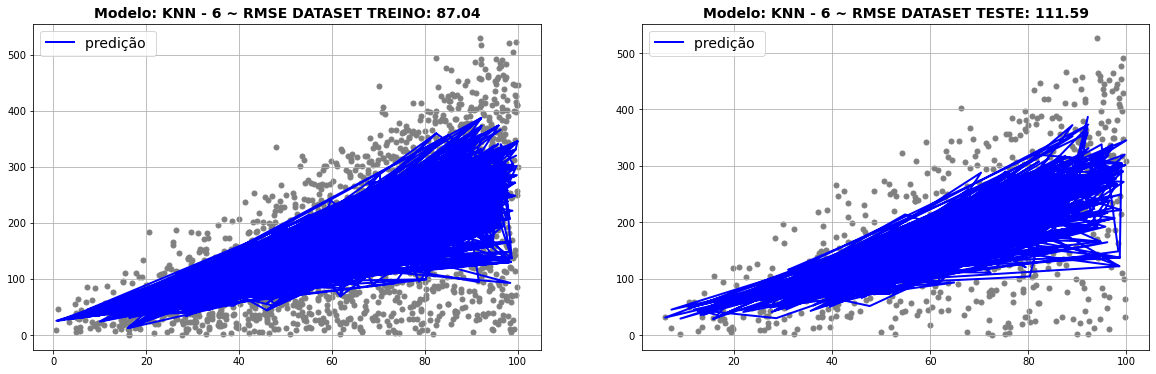

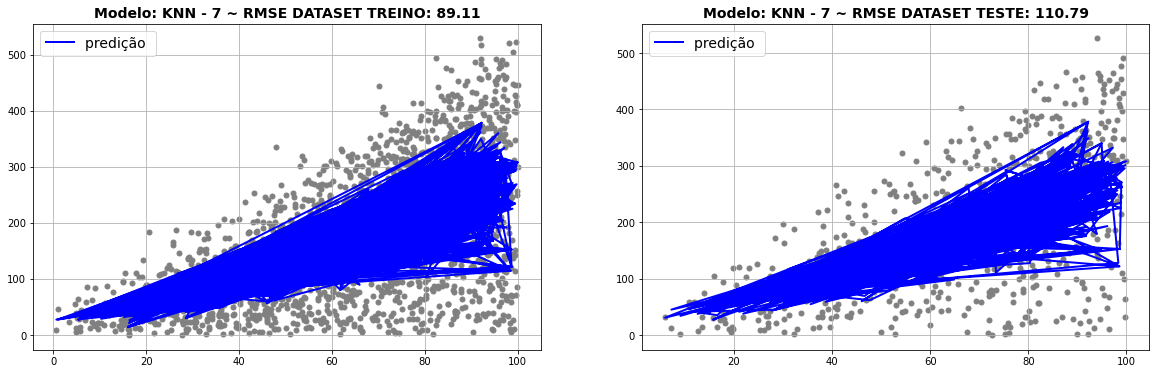

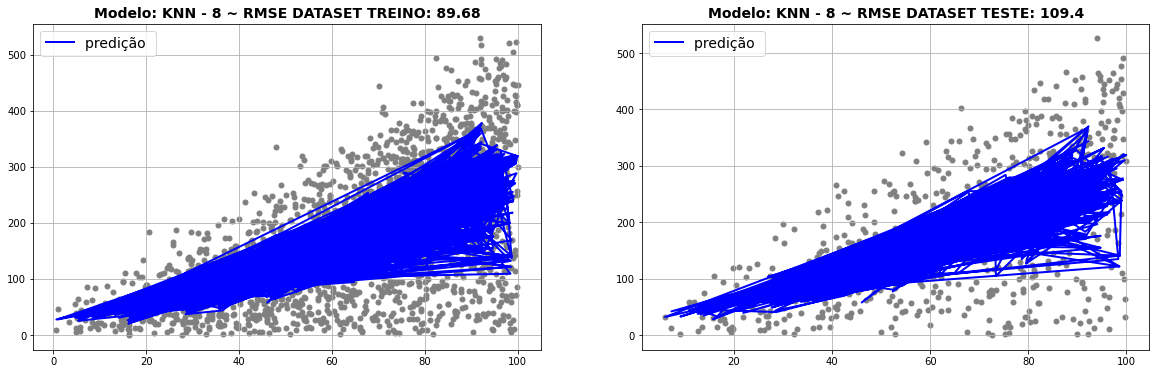

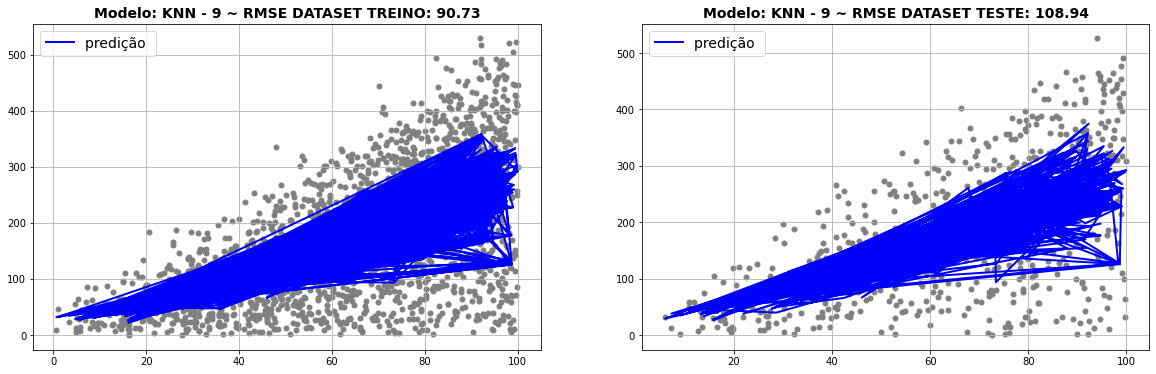

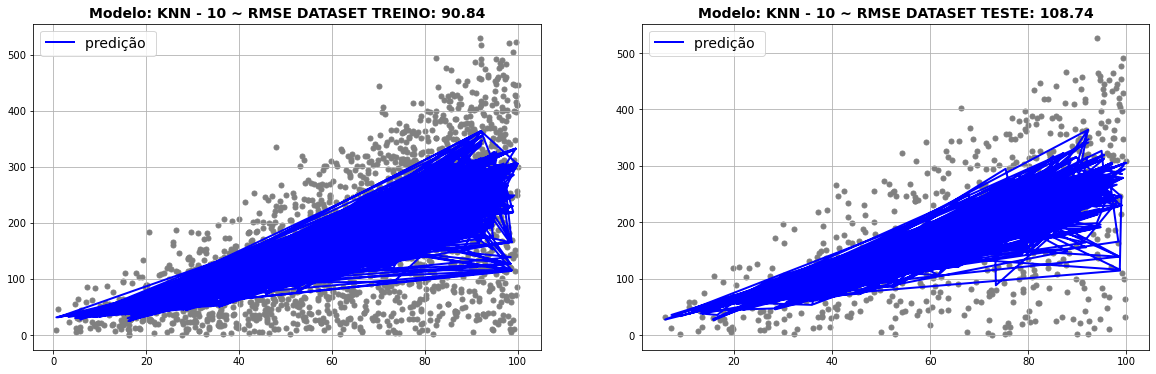

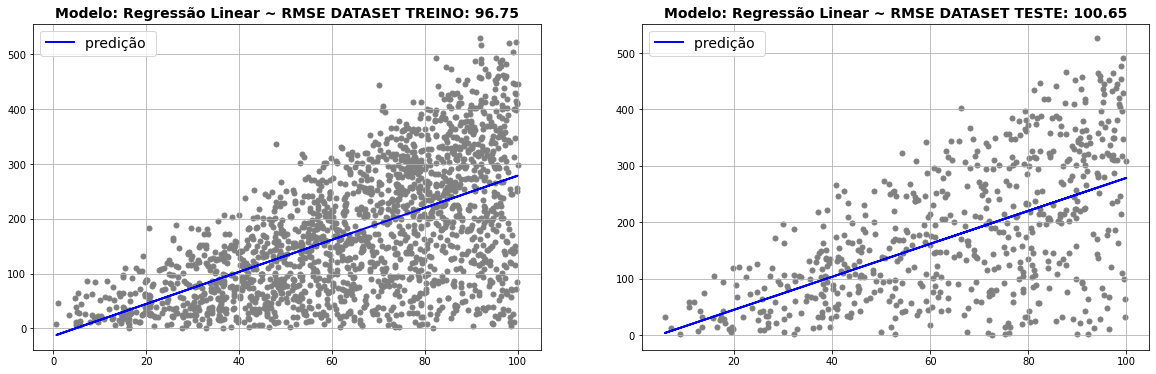

In [12]:
for num_vizinhos in range(1,11):
    modelo = KNeighborsRegressor(n_neighbors = num_vizinhos)
    nome_modelo = 'KNN - ' + str(num_vizinhos)
    plota_curva_regressao(X, y, Xi, yi, modelo, nome_modelo)
modelo = LinearRegression()
nome_modelo = 'Regressão Linear'
plota_curva_regressao(X, y, Xi, yi, modelo, nome_modelo)

In [13]:
def teste_regressao(X, y, Xi, yi, modelo, nome_modelo):
    
    modelo.fit(X, y)
    
    predicao_dataset_treino = modelo.predict(X)
    predicao_dataset_teste = modelo.predict(Xi)
    
    rmse_dataset_treino = np.round(RMSE(y = y, y_pred = predicao_dataset_treino), 2)
    rmse_dataset_teste = np.round(RMSE(y = yi, y_pred = predicao_dataset_teste), 2)
    
    print("Modelo: " + nome_modelo + " ~ RMSE DATASET TREINO: " + str(rmse_dataset_treino))
    print("Modelo: " + nome_modelo + " ~ RMSE DATASET TESTE: " + str(rmse_dataset_teste))
    diferenca_rmse = rmse_dataset_teste - rmse_dataset_treino
    print("Diferença de RMSE entre treino e teste: " + str(diferenca_rmse))

In [14]:
print("Conclusão\n\nConforme os gráficos acima, seguem as avaliações: \n\nO KNN possui dificuldade para as predições com um volume maior de dados. Conforme apresentado anteriormente, independente da quantidade de vizinhos a variar, nenhum deles conseguiu se ajustar tanto no treino como no teste, resultando no overfitting. Para o modelo de regressão linear, o modelo conseguiu se ajustar melhor ao modelo de teste, com uma diferença de RMSE menor em relação aos testes instanciados em KNN, conforme a listagem abaixo:\n")
for num_vizinhos in range(1,11):
    modelo = KNeighborsRegressor(n_neighbors = num_vizinhos)
    nome_modelo = 'KNN - ' + str(num_vizinhos)
    teste_regressao(X, y, Xi, yi, modelo, nome_modelo)
modelo = LinearRegression()
nome_modelo = 'Regressão Linear'
teste_regressao(X, y, Xi, yi, modelo, nome_modelo)

Conclusão

Conforme os gráficos acima, seguem as avaliações: 

O KNN possui dificuldade para as predições com um volume maior de dados. Conforme apresentado anteriormente, independente da quantidade de vizinhos a variar, nenhum deles conseguiu se ajustar tanto no treino como no teste, resultando no overfitting. Para o modelo de regressão linear, o modelo conseguiu se ajustar melhor ao modelo de teste, com uma diferença de RMSE menor em relação aos testes instanciados em KNN, conforme a listagem abaixo:

Modelo: KNN - 1 ~ RMSE DATASET TREINO: 0.0
Modelo: KNN - 1 ~ RMSE DATASET TESTE: 141.86
Diferença de RMSE entre treino e teste: 141.86
Modelo: KNN - 2 ~ RMSE DATASET TREINO: 67.8
Modelo: KNN - 2 ~ RMSE DATASET TESTE: 123.75
Diferença de RMSE entre treino e teste: 55.95
Modelo: KNN - 3 ~ RMSE DATASET TREINO: 78.86
Modelo: KNN - 3 ~ RMSE DATASET TESTE: 116.63
Diferença de RMSE entre treino e teste: 37.769999999999996
Modelo: KNN - 4 ~ RMSE DATASET TREINO: 83.09
Modelo: KNN - 4 ~ RMSE DATA

# Treinamento dos modelos com todas as variáveis exceto a alvo

Separação do dataframe entre treino e teste:

In [18]:
X2 = df_treino.values[:, :-1]
y2 = df_treino.values[:, -1]
Xi2 = df_teste.values[:, :-1]
yi2 = df_teste.values[:, -1]

Avaliação sobre o treinamento:

In [17]:
print("Conclusão\n\nConforme os gráficos acima, seguem as avaliações: \n\nO KNN obteve menores RMSE com a adição das outras variáveis no teste, mas ainda obteve uma diferença considerável entre treino e teste até KNN 4, significando Overfitting. Nos demais KNN > 4, apresentou-se uma diferença entre treino e teste menor que 10, mostrando melhor generalização destes ao dataset de teste. No modelo de regressão linear, este conseguiu se ajustar melhor ao modelo de teste, com uma diferença de RMSE menor em relação aos testes instanciados em KNN, conforme a listagem abaixo:\n")
for num_vizinhos in range(1,11):
    modelo = KNeighborsRegressor(n_neighbors = num_vizinhos)
    nome_modelo = 'KNN - ' + str(num_vizinhos)
    teste_regressao(X2, y2, Xi2, yi2, modelo, nome_modelo)
modelo = LinearRegression()
nome_modelo = 'Regressão Linear'
teste_regressao(X2, y2, Xi2, yi2, modelo, nome_modelo)

Conclusão

Conforme os gráficos acima, seguem as avaliações: 

O KNN obteve menores RMSE com a adição das outras variáveis no teste, mas ainda obteve uma diferença considerável entre treino e teste até KNN 4, significando Overfitting. Nos demais KNN > 4, apresentou-se uma diferença entre treino e teste menor que 10, mostrando melhor generalização destes ao dataset de teste. No modelo de regressão linear, este conseguiu se ajustar melhor ao modelo de teste, com uma diferença de RMSE menor em relação aos testes instanciados em KNN, conforme a listagem abaixo:

Modelo: KNN - 1 ~ RMSE DATASET TREINO: 0.0
Modelo: KNN - 1 ~ RMSE DATASET TESTE: 47.4
Diferença de RMSE entre treino e teste: 47.4
Modelo: KNN - 2 ~ RMSE DATASET TREINO: 22.0
Modelo: KNN - 2 ~ RMSE DATASET TESTE: 41.25
Diferença de RMSE entre treino e teste: 19.25
Modelo: KNN - 3 ~ RMSE DATASET TREINO: 25.67
Modelo: KNN - 3 ~ RMSE DATASET TESTE: 38.18
Diferença de RMSE entre treino e teste: 12.509999999999998
Modelo: KNN - 4 ~ RMSE